In [1]:
! pip install kagglehub numpy pandas tensorflow keras opencv-python matplotlib seaborn

In [2]:
import kagglehub
import shutil
import os
import numpy as np
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D


source_path = kagglehub.model_download("esfiam/pneumonia-detection-model/keras/v1.0")
destination_path = "./models/"
os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

source_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
destination_path = "./data/"
os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True) # fix
print(f"Dataset saved to: {destination_path}")

model = load_model('./models/model_Pneumonia_detection.keras')

2025-03-12 22:33:50.084599: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 22:33:51.687101: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-12 22:33:52.281807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741818832.834758  662016 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741818832.993857  662016 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741818834.276164  662016 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Dataset saved to: ./data/


2025-03-12 22:37:06.867880: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
def img_setting(path):
    img = load_img(path, target_size=(256, 256), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def mc_dropout_inference(img, nb_inference: int, model: Sequential) -> np.ndarray:
    return np.stack(
        [model({"input_layer_3": img}, training=True) for sample in range(nb_inference)], axis = -1
    )

def calculate_entropy(p):
    p = np.array(p)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))
    
from scipy.optimize import differential_evolution

def one_pixel_attack(img, model, pixel_count=1, bounds=(0, 1)):

    def evaluate_attack(pixels):
        perturbed = np.copy(img)
        for i in range(pixel_count):
            row, column, intensity = int(pixels[i*3]), int(pixels[i*3 + 1]), pixels[i*3 + 2]

            # batch, rows, columns, channel we have grayscale image so channel is 1, and the image is normalized
            perturbed[0, row, column, 0] = intensity  # Modify pixel

        # Get new prediction
        pred = model.predict(perturbed, verbose=0)[0][0]  # Probability of Pneumonia
        return pred  # Lower values = stronger attack

    # Define search bounds: (row, column, intensity) for each pixel
    # the bound is between (0, 1) because the pixel value is normalized (divide by 255)
    img_size = 256
    bounds = [(0, img_size), (0, img_size), bounds] * pixel_count


    result = differential_evolution(evaluate_attack, bounds, maxiter=20, popsize=10)

    # result has success attribute, and x which contains the result
    print(f"Attack :{result.success}")


    perturbed_img = np.copy(img)

    for i in range(pixel_count):
        x, y, intensity = int(result.x[i*3]), int(result.x[i*3+1]), result.x[i*3+2]
        perturbed_img[0, y, x, 0] = intensity  # Modify pixel

    return perturbed_img


def fgsm_attack(model, img, true_label, epsilon=0.007):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.Variable(img_tensor)  # Make it trainable

    # Compute loss within GradientTape
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)  # Track image for gradient computation
        prediction = model(img_tensor, training=False)
        true_label = tf.constant([[float(true_label)]], dtype=tf.float32)  # Convert to float tensor
        loss = tf.keras.losses.binary_crossentropy(true_label, prediction)

    gradient = tape.gradient(loss, img_tensor)
    signed_grad = tf.sign(gradient)

    # Apply perturbation to the original image
    adversarial_img = img + epsilon * signed_grad

    # Clip values to keep valid pixel range [0, 1]
    adversarial_img = tf.clip_by_value(adversarial_img, 0, 1)
    return adversarial_img, signed_grad, img_tensor


def extract_uncertainty_feature_maps(img, model, conv_layer_names, nb_inference=10):
    # Add the final layer name to conv_layer_names
    all_layer_names = conv_layer_names + ["dense_7"]

    # Define feature extractor model for multiple layers including final dense layer
    feature_extractor = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(name).output for name in all_layer_names]
    )

    # Repeat the input image `nb_inference` times to create a batch
    batch_imgs = np.repeat(img, nb_inference, axis=0)  # Shape: (10, 256, 256, 1)

    # Perform one forward pass with MC Dropout enabled
    feature_maps_batch = feature_extractor(batch_imgs, training=True)

    # Reshape feature maps: Convert from (10, H, W, C) to (H, W, C, 10)
    feature_maps = {
        layer_name: np.stack(np.split(feature_maps_batch[i], nb_inference, axis=0), axis=-1).squeeze(0)
        for i, layer_name in enumerate(all_layer_names)
    }

    entropy = calculate_entropy(feature_maps['dense_7'])
    # Compute mean and variance (uncertainty) across MC Dropout runs
    uncertainty_results = {
        layer_name: (np.mean(feature_maps[layer_name], axis=-1), np.var(feature_maps[layer_name], axis=-1))
        for layer_name in all_layer_names
    }

    avg_mu, avg_sigma = uncertainty_results['dense_7']
    del uncertainty_results['dense_7']

    return uncertainty_results, avg_mu, avg_sigma, entropy



def overlay_uncertainty_heatmap(img, model, conv_layer_names, nb_inference=10, threshold=10, mixing_alpha=0.6):


    # Extract uncertainty feature maps for multiple layers
    uncertainty_results, avg_pred_mu, avg_pred_var, entropy = extract_uncertainty_feature_maps(img, model, conv_layer_names, nb_inference)

    # Convert grayscale image to RGB
    img_rgb = cv2.cvtColor(img.reshape(256, 256), cv2.COLOR_GRAY2RGB)
    img_rgb = (img_rgb * 255).astype(np.uint8)

    # Plot original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(conv_layer_names) + 1, 1)
    plt.imshow(img.reshape(256, 256), cmap="gray")
    plt.title("Original X-ray")
    plt.axis("off")

    # Iterate over each layer and plot its uncertainty heatmap
    for i, (layer_name, (mean_feature_map, uncertainty_map)) in enumerate(uncertainty_results.items()):

       # Compute mean uncertainty across channels
        mean_uncer_map = np.mean(uncertainty_map, axis=-1)


        # Resize the uncertainty map to match the image size
        uncertainty_map_resized = cv2.resize(mean_uncer_map, (256, 256), interpolation=cv2.INTER_LINEAR)


        # Normalize to range 0-255
        uncertainty_map_resized = cv2.normalize(uncertainty_map_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # Thresholding to isolate high-uncertainty areas
        _, binary_mask = cv2.threshold(uncertainty_map_resized, threshold, 255, cv2.THRESH_BINARY)
        # binary_mask = np.ones_like(uncertainty_map_resized) * 255
        binary_mask_colored = cv2.merge([binary_mask, binary_mask, binary_mask]).astype(np.uint8)

        # Apply colormap to create a heatmap
        heatmap = cv2.applyColorMap(uncertainty_map_resized.astype(np.uint8), cv2.COLORMAP_JET)

        # Mask heatmap with high-uncertainty areas
        masked_heatmap = cv2.bitwise_and(heatmap, binary_mask_colored)

        img_rgb = cv2.cvtColor(img.reshape(256, 256), cv2.COLOR_GRAY2RGB)
        img_rgb = (img_rgb * 255).astype(np.uint8)

        # Blend heatmap with original image
        blended_image = cv2.addWeighted(img_rgb, 1 - mixing_alpha, masked_heatmap, mixing_alpha, 0)

        # Plot heatmap overlay
        plt.subplot(1, len(conv_layer_names) + 1, i + 2)
        plt.imshow(blended_image)
        plt.title(f"Uncertainty - {layer_name}")
        plt.axis("off")

    plt.show()
    print(f'PRED INTERVAL: {avg_pred_mu - avg_pred_var}, {avg_pred_mu + avg_pred_var}; ENTROPY: {entropy / nb_inference:.4}')

In [4]:
# get predictions on all the images and the entropy measure
# takes a long time to run and can crash your computer

normal_test_cases_path = glob("./data/chest_xray/test/NORMAL/*.jpeg")
pneumonia_test_cases_path = glob("./data/chest_xray/test/PNEUMONIA/*.jpeg")

mean_pred = []
entropy = []
mean_var = []
conv_layer = ["conv2d_12"]
for path in pneumonia_test_cases_path:
    img = img_setting(path)
    _, avg_pred_mu, avg_pred_var, entr = extract_uncertainty_feature_maps(
        img, model, conv_layer, 100
    )
    mean_pred.append(avg_pred_mu[0])
    mean_var.append(avg_pred_var[0])
    entropy.append(entr)

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(100, 256, 256, 1))
  warnings.warn(msg)


In [8]:
import pandas as pd
import seaborn as sns

pred_threshold = 0.5
results = pd.DataFrame({'mean_pred':mean_pred, 'mean_var': mean_var, 'entropy': entropy})
results['pred_condition'] = results.mean_pred.apply(lambda x: 'PNEUMONIA' if x > pred_threshold else 'NORMAL')
results.head()

mean_pred  mean_var    entropy pred_condition
0   0.745086  0.018448  29.723982      PNEUMONIA
1   0.559286  0.012663  45.195541      PNEUMONIA
2   0.996709  0.000051   0.470350      PNEUMONIA
3   0.991324  0.000154   1.234840      PNEUMONIA
4   0.991972  0.000166   1.141194      PNEUMONIA

In [6]:
results.value_counts('pred_condition')

pred_condition
PNEUMONIA    365
NORMAL        25
Name: count, dtype: int64

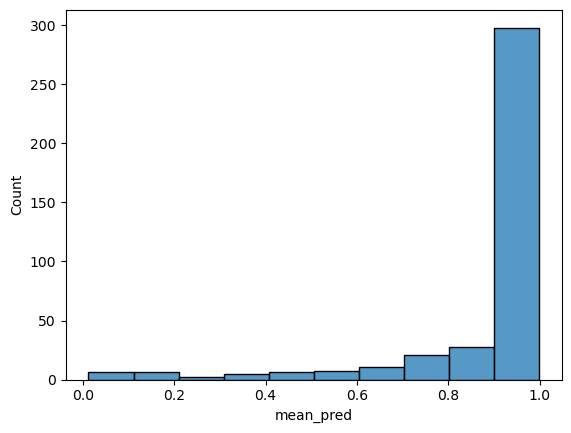

In [9]:
# look at the spread in the predictions
_ = sns.histplot(x='mean_pred', data=results, binwidth=0.1)

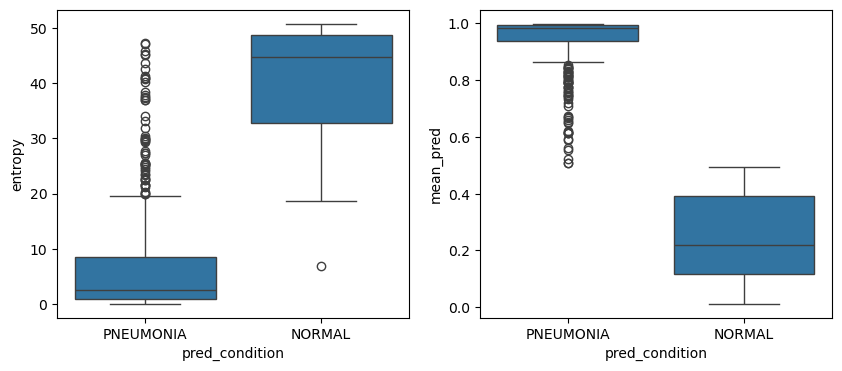

In [10]:
# boxplot entropy according to predictions.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
_ = sns.boxplot(x='pred_condition', y='entropy', data=results, ax=ax[0])
_ = sns.boxplot(x='pred_condition', y='mean_pred', data=results, ax=ax[1])

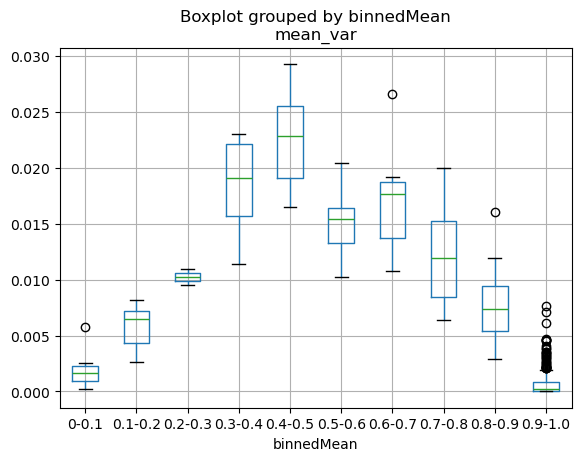

In [11]:
# check the quantile quantile plot
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5',
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
results['binnedMean'] = pd.cut(results['mean_pred'], bins=bins, labels=labels)
_ = results.boxplot(by='binnedMean', column='mean_var') 

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(100, 256, 256, 1))
  warnings.warn(msg)


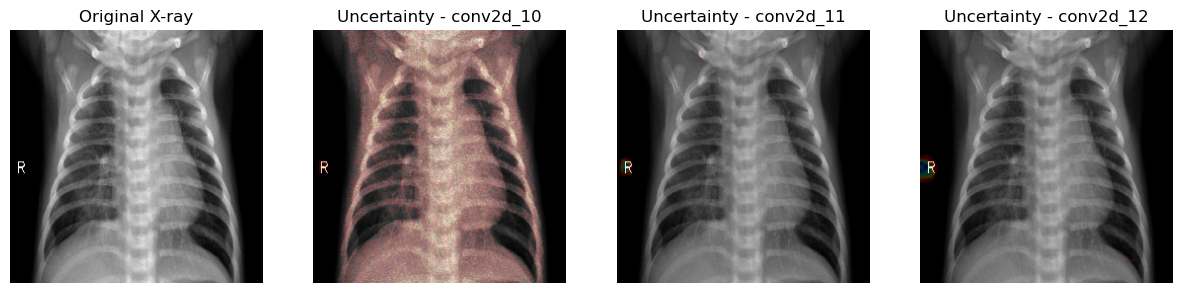

PRED INTERVAL: [0.05021615], [0.05353848]; ENTROPY: 0.2025


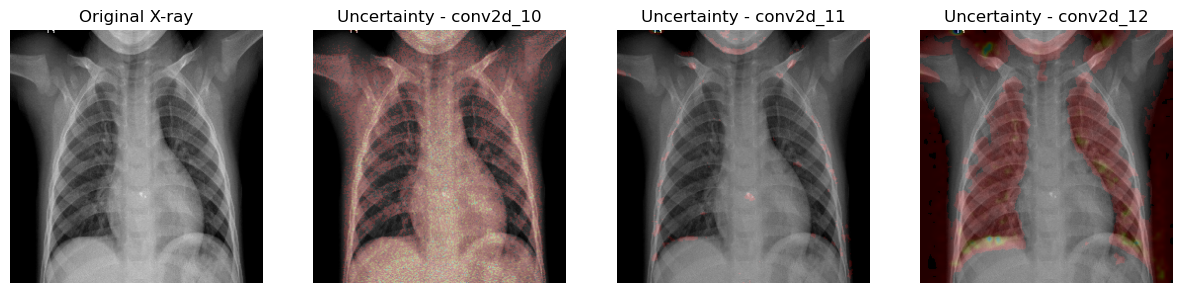

PRED INTERVAL: [0.07313763], [0.07609192]; ENTROPY: 0.2657


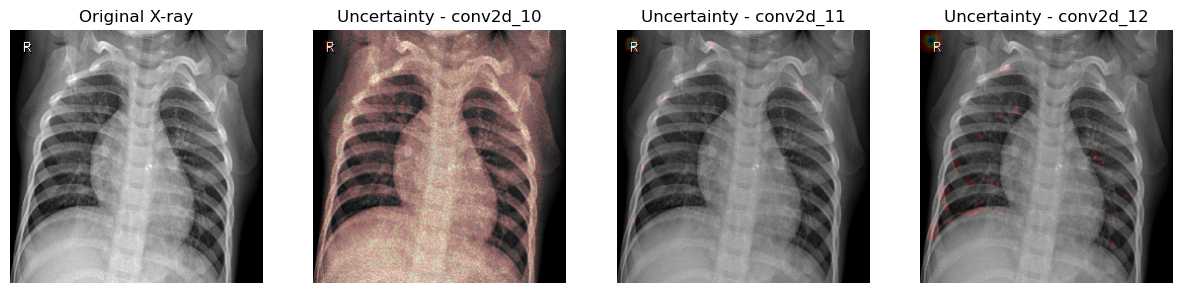

PRED INTERVAL: [0.01206091], [0.01238437]; ENTROPY: 0.07036


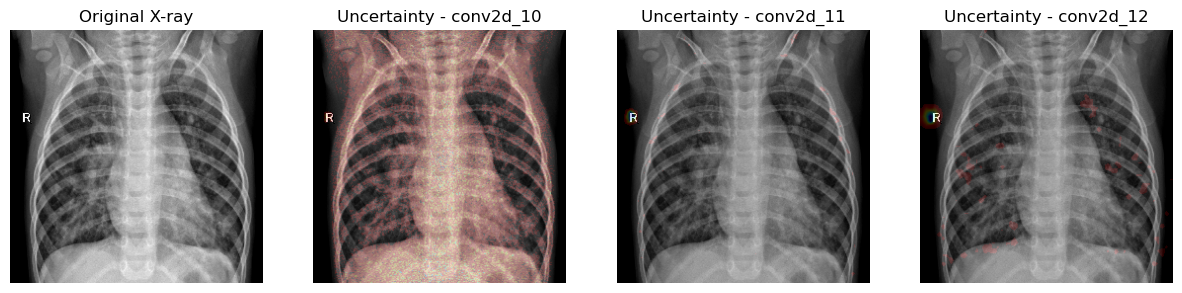

PRED INTERVAL: [0.0942909], [0.10412978]; ENTROPY: 0.2984


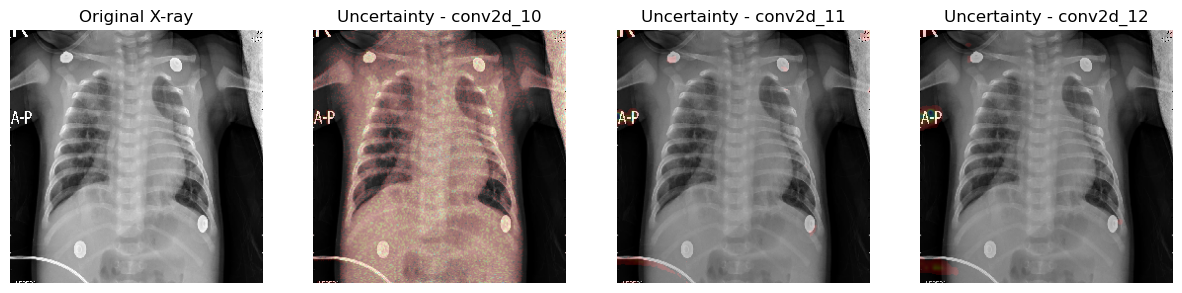

PRED INTERVAL: [0.06208962], [0.06585827]; ENTROPY: 0.2356


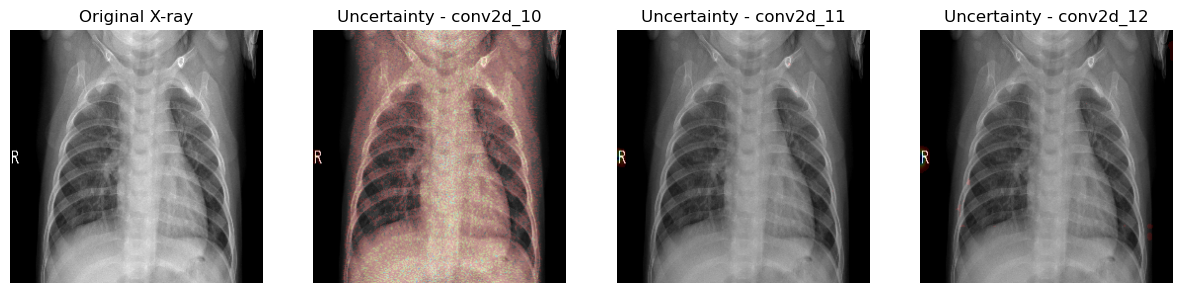

PRED INTERVAL: [0.06707233], [0.06996912]; ENTROPY: 0.2508


In [12]:
results['high_conf_false_negative'] = results.mean_pred <= 0.1


# check for feature map uncertainty in the images that were confidently predicted as being normal
false_neg_index = results.loc[results.high_conf_false_negative].index

conv_layers = ["conv2d_10", "conv2d_11", "conv2d_12"] 
for i in false_neg_index:
    img = img_setting(pneumonia_test_cases_path[i])
    overlay_uncertainty_heatmap(
    img,
    model,
    conv_layers,
    nb_inference=100,
    threshold=10,
    mixing_alpha=0.2
)

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(100, 256, 256, 1))
  warnings.warn(msg)


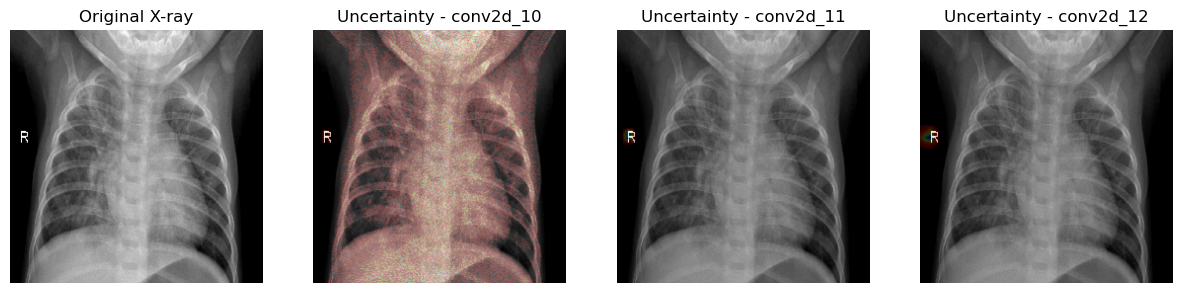

PRED INTERVAL: [0.13407964], [0.1420685]; ENTROPY: 0.3739


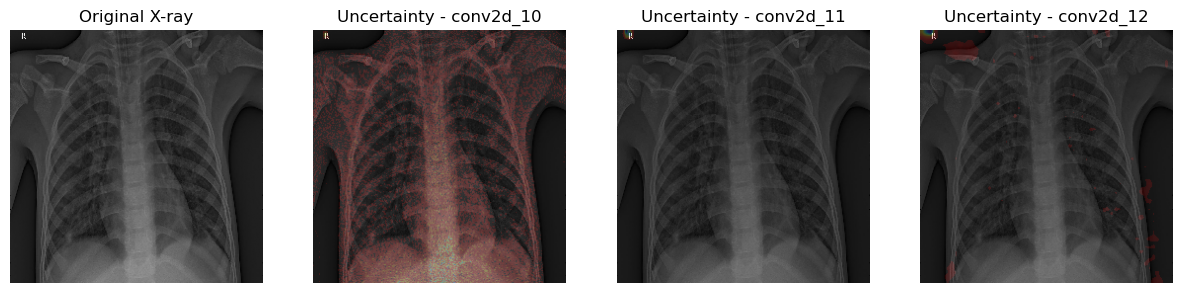

PRED INTERVAL: [0.19172688], [0.1993457]; ENTROPY: 0.4466


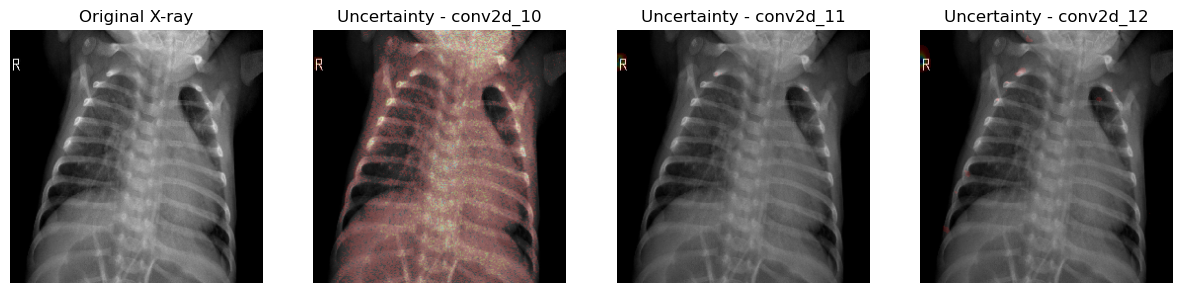

PRED INTERVAL: [0.14565516], [0.15398556]; ENTROPY: 0.3908


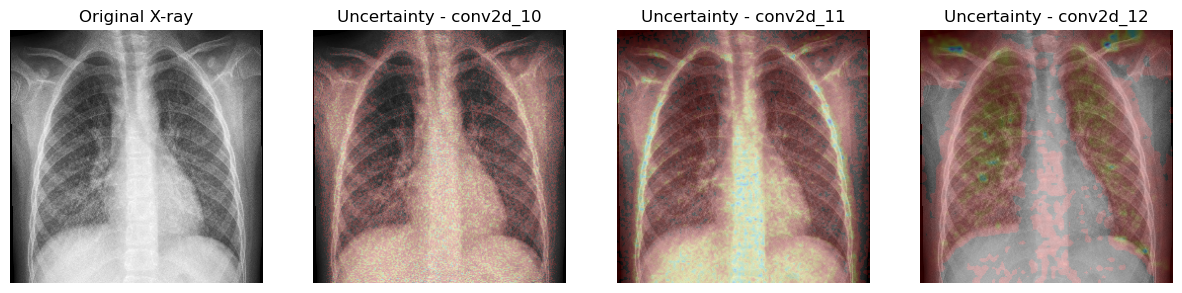

PRED INTERVAL: [0.17558748], [0.19076681]; ENTROPY: 0.419


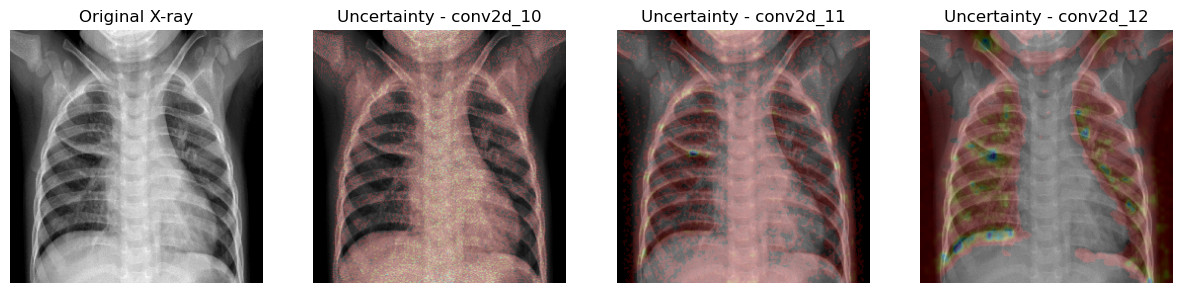

PRED INTERVAL: [0.1121463], [0.12316681]; ENTROPY: 0.3324


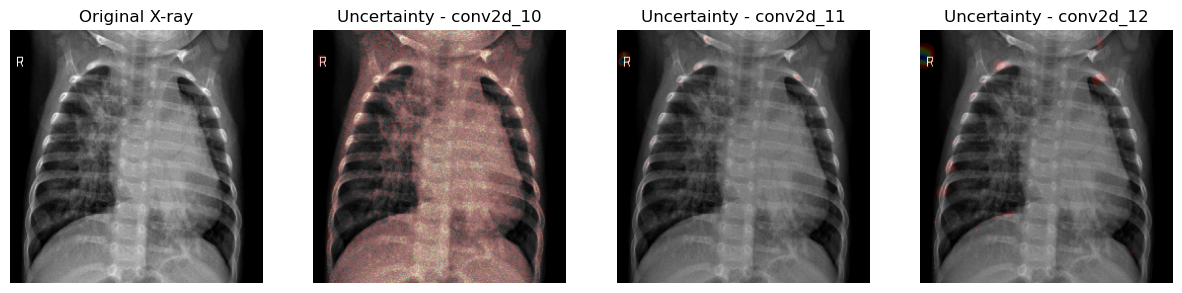

PRED INTERVAL: [0.10030844], [0.1092675]; ENTROPY: 0.3137


In [13]:
results['mid_conf_false_negative'] = (0.1 < results.mean_pred) & (results.mean_pred <= 0.2)


# check for feature map uncertainty in the images that were confidently predicted as being normal
false_neg_index = results.loc[results.mid_conf_false_negative].index

conv_layers = ["conv2d_10", "conv2d_11", "conv2d_12"] 
for i in false_neg_index:
    img = img_setting(pneumonia_test_cases_path[i])
    overlay_uncertainty_heatmap(
    img,
    model,
    conv_layers,
    nb_inference=100,
    threshold=10,
    mixing_alpha=0.2
)

In [14]:
pneumonia_img_paths = glob("./data/chest_xray/test/PNEUMONIA/*.jpeg")
true_positive_img = "./data/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg"
load_img(true_positive_img, target_size=(256, 256), color_mode='grayscale') # rows, columns
original_img = img_setting(true_positive_img)
adv_img = one_pixel_attack(original_img, model, pixel_count=1)
original_pred = model.predict(original_img, verbose=0)[0][0]
adv_pred = model.predict(adv_img, verbose=0)[0][0]
print(f'No attack prediction {original_pred:.4f}')
print(f'Attack Prediction {adv_pred:.4f}')

I0000 00:00:1741821535.744887  662341 service.cc:152] XLA service 0x7f0204007fe0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741821535.745246  662341 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-03-12 23:18:56.371159: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741821538.385478  662341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Attack :True
No attack prediction 0.9954
Attack Prediction 0.9955


In [15]:
# increasing pixel count to 100 does not work
adv_img = one_pixel_attack(original_img, model, pixel_count=100)
original_pred = model.predict(original_img, verbose=0)[0][0]
adv_pred = model.predict(adv_img, verbose=0)[0][0]
print(f'No attack prediction {original_pred:.4f}')
print(f'Attack Prediction {adv_pred:.4f}')

Attack :True
No attack prediction 0.9954
Attack Prediction 0.9970


No attack prediction 0.9954
Attack Prediction 0.9896


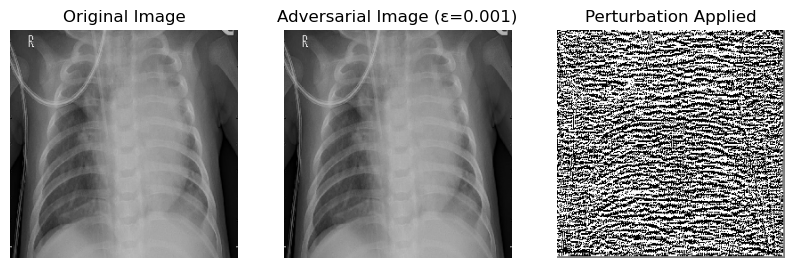

--------------------------------------------------------------------------------
No attack prediction 0.9954
Attack Prediction 0.8035


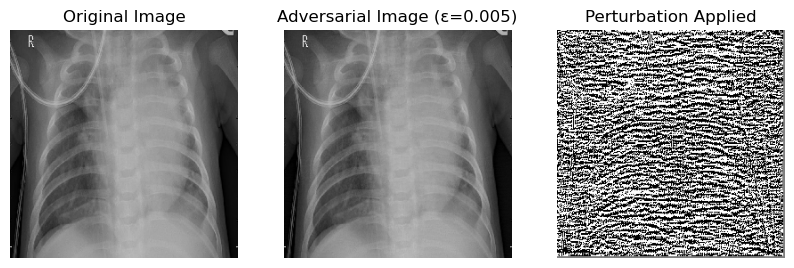

--------------------------------------------------------------------------------
No attack prediction 0.9954
Attack Prediction 0.6871


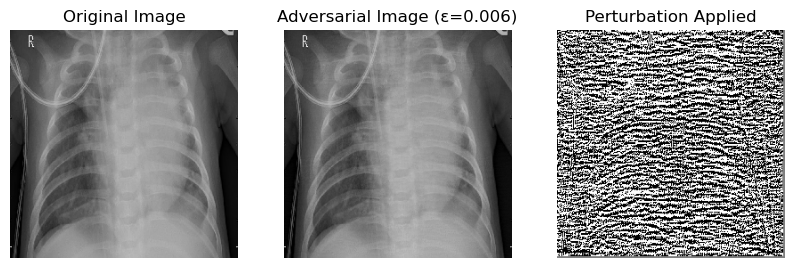

--------------------------------------------------------------------------------
No attack prediction 0.9954
Attack Prediction 0.5637


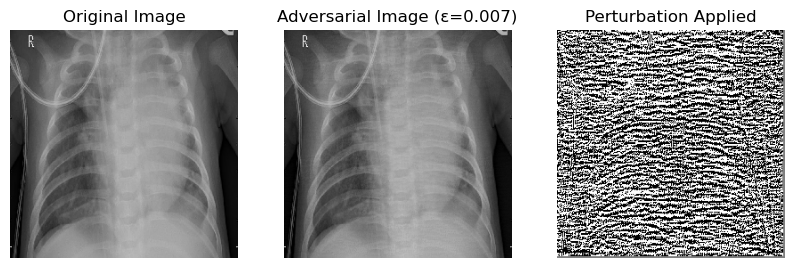

--------------------------------------------------------------------------------
No attack prediction 0.9954
Attack Prediction 0.4467


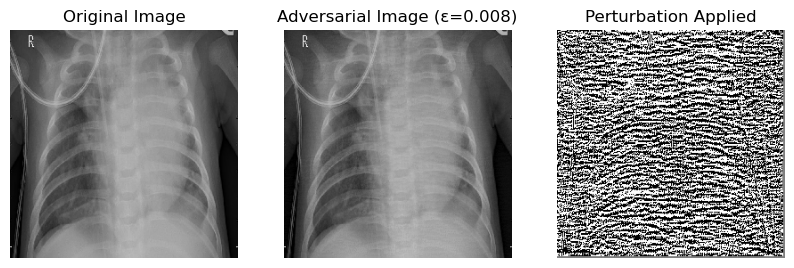

--------------------------------------------------------------------------------
No attack prediction 0.9954
Attack Prediction 0.2803


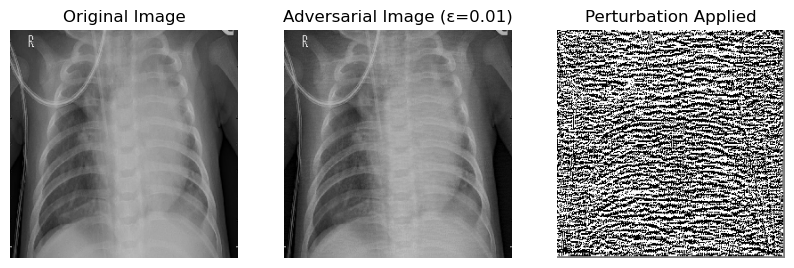

--------------------------------------------------------------------------------


In [16]:

for eps in [0.001, 0.005, 0.006, 0.007, 0.008, 0.01]:
    adv_img, perturbation, ret_img = fgsm_attack(model, original_img, 1, eps)
    
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(ret_img[0, :, :, 0], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(adv_img[0, :, :, 0], cmap="gray")
    plt.title(f"Adversarial Image (ε={eps})")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(perturbation[0, :, :, 0], cmap="gray")
    plt.title("Perturbation Applied")
    plt.axis("off")
    
    original_pred = model.predict(original_img, verbose=0)[0][0]
    adv_pred = model.predict(adv_img, verbose=0)[0][0]
    print(f'No attack prediction {original_pred:.4f}')
    print(f'Attack Prediction {adv_pred:.4f}')
    
    plt.show()

    print("--------------------------------------------------------------------------------")

In [17]:
eps = 0.01
adv_img, perturbation, ret_img = fgsm_attack(model, original_img, 1, eps)

original_pred = model.predict(original_img, verbose=0)[0][0]
adv_pred = model.predict(adv_img, verbose=0)[0][0]
mc_dropout_pred = np.mean(mc_dropout_inference(np.array(adv_img), 100, model))

print(f'No attack prediction {original_pred*100:.4f} %')
print(f'Attack Prediction {adv_pred*100:.4f} %')
print(f'MC Dropout Prediction {mc_dropout_pred*100:.4f} %')

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(1, 256, 256, 1))']
  warnings.warn(msg)


No attack prediction 99.5398 %
Attack Prediction 28.0334 %
MC Dropout Prediction 29.8783 %
